# Example 3: Optimized hyperparameters

In [3]:
import sys
sys.path.append('../')
from lgcpspatial.load_data import Dataset

L        = 128 # Grid size for position bins
pad      = 0.1 # Edge padding
datadir  = '../example data/'
datasets = [
    'r2405_051216b_cell1816.mat',
    'R11_20190607_EC_02.mat'
]
dataset = datasets[1]

# Load a dataset
fn = datadir + dataset
data = Dataset.from_file(fn,pad)
data.prepare(L,doplot=False)

# Start with heuristic kernel parameters
P  = data.P
kv = data.prior_variance

## Use grid search to find kernel hyperparameters with largest evidence lower-bound

In [8]:
from numpy import *
from lgcpspatial.grid_search import grid_search
from lgcpspatial.lgcp2d import DiagonalFourierLowrank, coordinate_descent

def evaluate_ELBO(parameters,state):
    '''
    Perpare a function like this to help
    grid search know which parameters are good.
    
    Parameters
    ----------
    Parameters: tuple
        Parameters taken from the parameter search grid
    State: List of arrays
        Saves initial conditions (optional, default None)

    Returns
    -------
    state: the inferred model fit, in the form of a list 
        of floating-point numpy arrays, to be re-used as 
        initial conditions for subsequent parameters.
    log likelihood: float
        Scalar summary of fit quality, higher is better
    info: object
        Anything else you'd like to save
    '''
    p,β     = parameters
    μ,v,mh  = (None,)*3 if state is None else state
    model   = DiagonalFourierLowrank(kv/β,p,data,kclip=3)
    μ0      = None if μ is None else model.F@μ
    v0      = None if v is None else v*0.5
    mh,v,nl = coordinate_descent(model,μ0,v0)
    μ       = model.F.T@mh 
    state   = μ,v,mh
    loglike = -nl
    return state, loglike, model

# Prepare hyperparameter grid
rP = 4   # Range (ratio) to search for optimal period
rβ = 150 # Range (ratio) to search for optimal kernel height
NP = 201 # Period search grid resolution
Nβ = 201 # Kernel height search grid resolutions
Ps = float32(exp(linspace(log(P/rP),log(P*rP),NP)))
βs = float32(exp(linspace(log(1/rβ),log(1*rβ),Nβ))[::-1])
pargrid = [Ps,βs]

# Run overall grid search
bestindex,bestpars,bestresult,allresults = grid_search(pargrid,evaluate_ELBO)

print('')
print('Heuristic parameters')
print('P  = %f'%P)
print('v0 = %f'%kv)
print('')
print('Optimized parameters:')
print('P    = %f'%bestpars[0])
print('β    = %f'%bestpars[1])
print('v0/β = %f'%(kv/bestpars[1]))

[101,108](1.17e+01,6.70e-01) loss=-4.837745e+03(done)

Heuristic parameters
P  = 11.499551
v0 = 0.069208

Optimized parameters:
P    = 11.499552
β    = 0.669750
v0/β = 0.103334


## The heuristic parameters were close to optimal in this case

***Note:*** Since each time-sample adds independent information, it is helpful to normalize the evidence lower bound (ELBO). 
By default, `coordinate_descent` returns the negative ELBO, sometimes called the variational free energy,
in units of nats-per-dataset. We can convert this to a more useful bits-per-second by:

1. Dividing by the total number of time samples, giving nats per sample
2. Multiply by `log2(e)` to convert to bits per sample
3. Multiplying by samples/second to get bits per second

This (negative) ELBO is also missing a $\ln(y!) = \ln\Gamma(y+1)$ term from the Poisson negative log-likelihood. This doesn't affect state or hyperparameter optimization, but it's good to add it back for completeness.

Text(0.5, 0.98, 'R11_20190607_EC_02.mat: Optimised parameters, ELBO=-0.728810 bits/second')

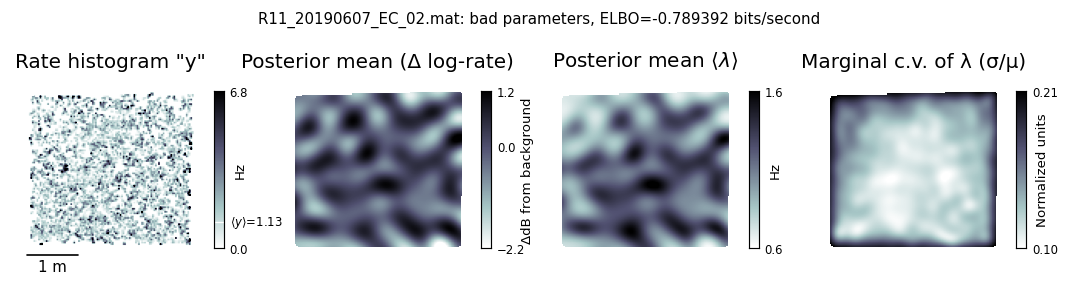

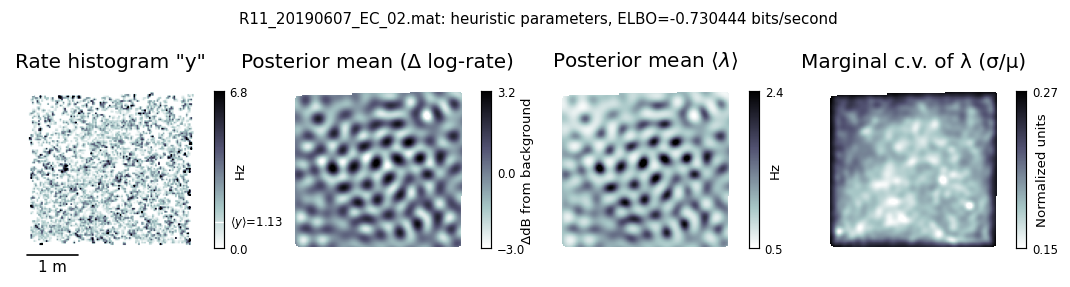

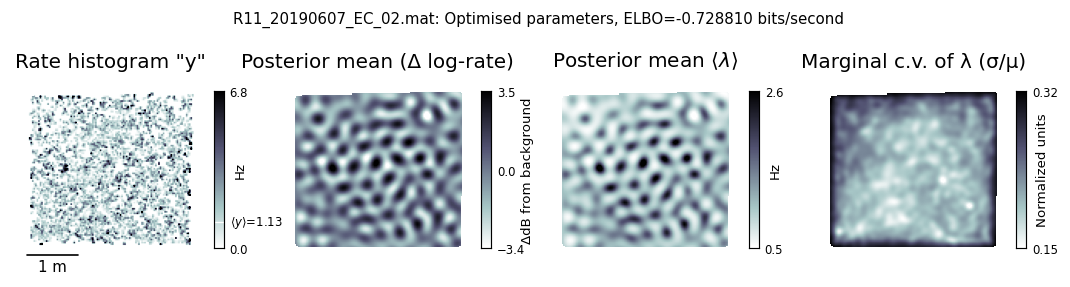

In [12]:
from scipy.special   import loggamma as lnΓ
from lgcpspatial.plot import *

mask,mz = data.arena.mask,data.prior_mean
Fs      = data.position_sample_rate
scale   = data.scale
y,N     = data.y,data.n

inbitspers = log2(e)*Fs
correction = average(lnΓ(data.y+1),weights=data.n)

P_use    = P*2
v0_use   = kv
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,dataset)
suptitle('%s: bad parameters, ELBO=%f bits/second'%\
         (dataset,-inbitspers*(vfe/sum(N)+correction)))

P_use    = P
v0_use   = kv
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,dataset)
suptitle('%s: heuristic parameters, ELBO=%f bits/second'%\
         (dataset,-inbitspers*(vfe/sum(N)+correction)))

P_use    = bestpars[0]
v0_use   = kv/bestpars[1]
model    = DiagonalFourierLowrank(v0_use,P_use,data)
mh,v,vfe = coordinate_descent(model,tol=1e-6)
inference_summary_plot(model,mask,y,mh,mz,v,Fs,L,scale,dataset)
suptitle('%s: Optimised parameters, ELBO=%f bits/second'%\
         (dataset,-inbitspers*(vfe/sum(N)+correction)))